In [1]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt

## General functions

In [56]:
def U3_rotation(theta,phi,lambda_):
    """Rotation matrix for a single qubit."""
    U = th.tensor(
            [[np.cos(theta / 2)                     , -np.exp(1j * lambda_) * np.sin(theta / 2)         ],
            [np.exp(1j * phi) * np.sin(theta / 2)   , np.exp(1j * (phi+lambda_)) * np.cos(theta / 2)    ]],
            dtype=th.complex128)
    return U

def X_rotation(theta):
    U = th.tensor(
            [[np.cos(theta / 2)                     , -1j * np.sin(theta / 2)         ],
            [-1j * np.sin(theta / 2)               , np.cos(theta / 2)              ]],
            dtype=th.complex128)
    return U

def global_rotation(angles,N):
    """Apply a global rotation to the state vector."""

    U = U3_rotation(angles[0,0], angles[0,1], angles[0,2])

    for i in range(1,N):
        U_i = U3_rotation(angles[i,0], angles[i,1], angles[i,2])
        U = th.kron(U, U_i)
    return U


def cnot_gates(N):
    """Return a n-1 cascading CNOT."""

    cnot = th.tensor([
                [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 1, 0]
        ], dtype=th.complex128)
    
    cnot_gates = []
    
    for i in range(N-1):    
        p1 = i
        p2 = N-i-2

        Id1 = th.eye(2**p1, dtype=th.complex128)
        Id2 = th.eye(2**p2, dtype=th.complex128)

        cnot_gates.append(th.kron(Id1, th.kron(cnot, Id2)))
    
    return cnot_gates

def crx_gates(N, theta=np.pi/20):
    """Return a controlled RX gate with rotation angle theta."""
    Id = th.eye(2, dtype=th.complex128)
    Rx = X_rotation(theta)
    crx = th.block_diag(Id, Rx)

    crx_gates = []
    
    for i in range(N-1):    
        p1 = i
        p2 = N-i-2

        Id1 = th.eye(2**p1, dtype=th.complex128)
        Id2 = th.eye(2**p2, dtype=th.complex128)

        crx_gates.append(th.kron(Id1, th.kron(crx, Id2)))
    return crx_gates


def generate_ghz(N):
    state = th.zeros(2**N, dtype=th.complex128)
    state[0] = 1/np.sqrt(2)
    state[-1] = 1/np.sqrt(2)
    return state


def generate_H(N):
    h = 9/N
    scale = 2**(N/2)

    Z = th.tensor([[1, 0], [0, -1]], dtype=th.complex128)

    ZZ = th.kron(Z, Z)

    H = th.zeros(2**N, 2**N, dtype=th.complex128)

    for i in range(N-1):
        H += th.kron( th.eye(2**i), th.kron(ZZ, th.eye(2**(N-i-2))) )

    return h*scale*H

## Density matrix computation

In [57]:
def generate_ghz_dm(N):
    """Generate a GHZ state for N qubits."""
    ghz_state = generate_ghz(N)
    return th.outer(ghz_state, ghz_state)


def layer(state, angles, N, gates):
    """Apply a layer of gates to the state vector."""
    U = global_rotation(angles,N)
    
    # Apply the rotation
    state = U @ state @ U.adjoint()
    
    # Apply CNOT gates
    for gate in gates:
        state = gate @ state @ gate.adjoint()
    
    return state

def calc_variance(N,L,p,n_sim=100, fast_ent=True):

    ghz = generate_ghz_dm(N)
    H = generate_H(N)
    if fast_ent:
        ent_gates = cnot_gates(N)
    else:
        ent_gates = crx_gates(N)

    obs = []

    for _ in range(n_sim):
        state = th.zeros(2**N,2**N, dtype=th.complex128)
        state[0,0] = 1.0  # |000>

        params1 = np.arccos(np.ones((L,N)) - 2*np.random.uniform(0,1,size=(L, N)))
        params2 = np.random.uniform(0, 2*np.pi, size=(L, N))
        params3 = np.random.uniform(0, 2*np.pi, size=(L, N))

        params = np.stack((params1, params2, params3), axis=2)

        for i in range(L):
            state = p * ghz + (1-p) * layer(state, params[i], N, ent_gates)

        # Run the circuit
        obs.append(th.trace(state @ H).real)
    
    return np.mean(obs), np.std(obs)


In [58]:
calc_variance(3,10,1)

(np.float64(16.970562748477136), np.float64(3.552713678800501e-15))

### Different sizes

In [117]:
ps = np.linspace(0, 0.5, 7)
variances1 = [calc_variance(3, 9, p, n_sim=200)[1] for p in ps]
variances2 = [calc_variance(5, 9, p, n_sim=200)[1] for p in ps]

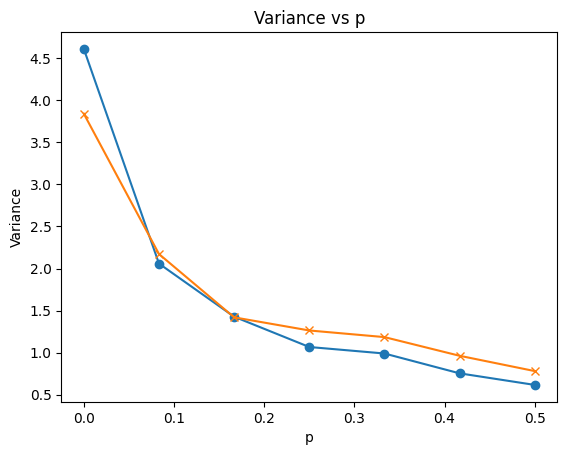

In [118]:
plt.plot(ps, variances1, marker='o')
plt.plot(ps, variances2, marker='x')
plt.xlabel('p')
plt.ylabel('Variance')
plt.title('Variance vs p')
plt.show()

### Slow vs Fast Entangling

In [59]:
ps = np.linspace(0, 0.5, 7)
variances1 = [calc_variance(5, 9, p, n_sim=200, fast_ent=True)[1] for p in ps]
variances2 = [calc_variance(5, 9, p, n_sim=200, fast_ent=False)[1] for p in ps]

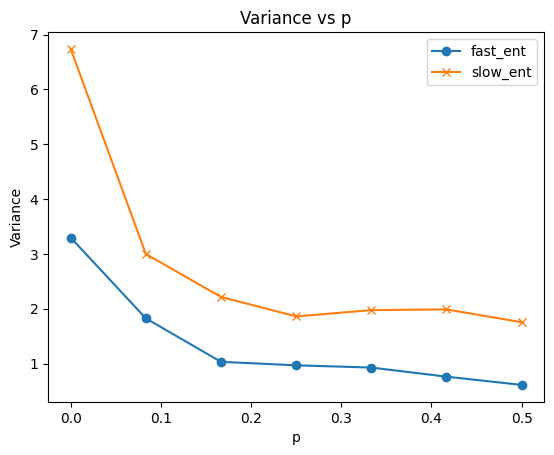

In [61]:
plt.plot(ps, variances1, marker='o', label='fast_ent')
plt.plot(ps, variances2, marker='x', label='slow_ent')
plt.xlabel('p')
plt.ylabel('Variance')
plt.title('Variance vs p')
plt.legend()
plt.show()

## (**BROKEN**) Optimized state vector computation

In [76]:
def layer(state, angles, N):
    """Apply a layer of gates to the state vector."""
    U = global_rotation(angles,N)
    
    # Apply the rotation
    state = U @ state

    CNOT_gates = cnot_gates(N) 
    
    # Apply CNOT gates
    for cnot in CNOT_gates:
        state = cnot @ state
    
    return state


def generate_dm(N,L,p):
        
    dm_state = th.zeros(2**N,2**N, dtype=th.complex128)
    n_run = 100

    for _ in range(n_run):
        # Sample whether to entangle or use CNOT at each layer
        entangle_flags = np.random.rand(L) < p  # Boolean array

        last_true_idx = np.where(entangle_flags)[0][-1] if np.any(entangle_flags) else 0

        l = L - last_true_idx   # number of effective layers
        
        params = np.random.uniform(0, np.pi, size=(l, N))
        
        state = generate_ghz_dm(N) 

        for i in range(l):
            state = layer(state, params[i], N)

        dm_state += state.adjoint() @ state

    return dm_state / n_run


def calc_variance(N,L,p):
    n_sim = 1000

    H = generate_H(N)

    res = []

    for _ in range(n_sim):
        
        state = generate_dm(N,L,p)

        # Run the circuit
        res.append(th.trace(state @ H).real)
    
    return np.std(res)


In [77]:
calc_variance(2, 3, 0.1)

1.6870714703406642e-15

In [48]:
import cProfile

cProfile.run("calc_variance(4, 8, 0.1)")

         1846541 function calls in 7.605 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   228016    0.913    0.000    1.934    0.000 2310274791.py:1(rotation)
    57004    0.274    0.000    3.040    0.000 2310274791.py:10(global_rotation)
    57004    0.442    0.000    2.680    0.000 2310274791.py:21(cnot_gates)
    10000    0.235    0.000    0.292    0.000 2310274791.py:44(generate_ghz)
        1    0.000    0.000    0.001    0.001 2310274791.py:51(generate_H)
    57004    0.945    0.000    6.665    0.000 2368915923.py:1(layer)
      100    0.338    0.003    7.600    0.076 2368915923.py:17(generate_dm)
        1    0.002    0.002    7.604    7.604 2368915923.py:42(calc_variance)
    10000    0.009    0.000    0.371    0.000 6946541.py:1(generate_ghz_dm)
        1    0.000    0.000    7.604    7.604 <string>:1(<module>)
        1    0.000    0.000    0.001    0.001 _methods.py:135(_var)
        1    0.000    0.000    0.00